In [1]:
# package(s) related to time, space and id
import datetime

# Used for mathematical functions
import math
import platform
import time

import matplotlib.pyplot as plt

# Used for making the graph to visualize our problem
import networkx as nx

# package(s) for data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import itertools
import tqdm

import plotly.express as px
from plotly.subplots import make_subplots
# spatial libraries
import pyproj
import shapely.geometry

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
from simplekml import Kml, Style

## U_rel calculation and plotting starts from here 
- define function
- set input value
- arrange input table
- use the defined function and get output table
- select desired variables for plotting

#### define function

In [2]:
# Shallow water factor
def get_swf (T, h):
    
    swf = 1/(1-np.exp(4*(1-max([h/T, 1.1]))))
    return swf

### Return flow due to interaction of Boundary layer between ship and bed
def get_Umaxship (Bs, T, h, Uo, V):
    if h/T <= 1.6:
        #Ur = 0.32 * V * ((Bs/h-T)** 0.25) - (0.36 * Uo * ((h/h-T)** (3/4)))
        Ur= 0.6 * V * ( (T / h )** 1.2) - 1.5 * Uo * ((h / Bs)** (1/3))
    else:
        Ur = 1.07 * (V+Uo) * ( (T / h )** 1.82) * ((Bs / h)** 0.08)
    return Ur

# Adjusted velocity 
def get_Vadj (Bs, Bc, V, T, h, Ls, swf):
   
    # get blockage factor
    Am = Bs * T
    Ac = Bc * h
    Blockage = Am / Ac
    r = h/T
    # get limit speed
    #if  0 < Blockage <= 0.1:
        #Vlim = np.sqrt (9.81*Ls/2*np.pi)
        
    if 0.1 < Blockage <= 0.3:
        Vlim = 0.78 * (np.sqrt(h*9.81)) * ((1 - Blockage)**2.25)
    else:
        Vlim = np.sqrt (9.81*h)
        #Vlim = (np.sqrt(8*h*9.81))* (np.cos((3.14+(np.cos(1- Blockage))**-1))/3)**1.5
        #Vlim = np.sqrt (9.81*Ls/2*np.pi)

    # get shallow speed     
    Vsh= 1.18 * V * (swf**(-0.75 - Blockage))
     
    #get adjusted velocity
    if Vsh <= 0.9 * Vlim and Vsh < V:
        Vadj = Vsh
    if V < 0.9 * Vlim and V < Vsh:
        Vadj = V 
    else:
        Vadj =min([V, 0.9 * Vlim, Vsh])
    return Vlim, r, Vadj

# Relative velocity
def get_Urel (h, T, Ur, Vadj, swf): 
    Unarrow = Ur + Vadj
    Ushallow = swf * Vadj
    Urel = max([Unarrow, Ushallow])
    
    return Urel, Unarrow, Ushallow

####Rf
def get_Rf (Bs, Urel, T, Ls):
    
    # get cf
    Re = (Urel*Ls)/ (10**(-6))
    cf = 0.053 /((np.log10(Re)-2)**2)
    
    Rf = 1.4 * 0.5 *(Urel**2) * cf * (Bs *Ls + 2 * Ls * T)
    return  Rf

####Rp
def get_Rp (Vadj, T):
    Rp = 0.5 *(Vadj**2) * 0.15 * (Bs * T)
    return Rp


####Rz
def get_Rz (Bs, Bc, T, h, Vadj):
    
    # get blockage factor
    Am = Bs * T
    Ac = Bc * h
    Blockage = Am / Ac
    
    # get Froude number
    Frh = Vadj / np.sqrt(h*9.81)
    
    #get z
    z = (Blockage/(1-Blockage-(Frh**2))) * (Frh**2) * h
    
    Rz = 9.81 *z * 0.2 * (Bs * T)
    return Rz

####Rtot
def get_Rtot(Rp, Rf, Rz):
    
    Rtot =  Rp + Rf + Rz 
    return Rtot
########Power
def get_Pe ():
    Pe =  Vadj * Rtot #m/s * kN = kW
    return Pe

# 2) Delivered horse power Pd (Power delivered to the propeller shaft)
def get_Pd ():
    Pd = (Urel * Rtot)/ 0.55
    return Pd

# 3) Brake horse power or Propulsion power Pb (Required motor power)
def get_Pb ():
    Pb = 2*Pd
    return Pb

#### input value for Urel

In [3]:
# M8 motor vessel
h = np.linspace(4,10,25)  # water depth from 3 m to 10 m is a suitable range for the Ductch waterways 
h_more = np.linspace(4,10,25)
V_more = np.linspace(0,6,25)
Bs = [11.4]
Bc= [150] 
V = [3]
T = [2.7]
Ls = [110]
Uo = [-1] #ambient flow for amsterdam-rhine canal

#### prepare input matrix for calculation

In [4]:
V_more = np.linspace(0,6,25)
V_more

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
       5.5 , 5.75, 6.  ])

In [5]:
h_more = np.linspace(3,10,29)
h_more

array([ 3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,  4.5 ,  4.75,  5.  ,
        5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,  7.  ,  7.25,
        7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,  9.25,  9.5 ,
        9.75, 10.  ])

In [6]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product( h_more, Bs, Bc, V_more, T, Ls, Uo))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"h_more": item[0],"Bs": item[1], "Bc": item[2], "V_more": item[3], "T": item[4], "Ls": item[5], "Uo": item[6]}
    rows.append(row)

# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.head(50)

,h_more,Bs,Bc,V_more,T,Ls,Uo
0,3.00,11.4,150,0.00,2.7,110,-1
1,3.00,11.4,150,0.25,2.7,110,-1
2,3.00,11.4,150,0.50,2.7,110,-1
3,3.00,11.4,150,0.75,2.7,110,-1
4,3.00,11.4,150,1.00,2.7,110,-1
5,3.00,11.4,150,1.25,2.7,110,-1
6,3.00,11.4,150,1.50,2.7,110,-1
7,3.00,11.4,150,1.75,2.7,110,-1
8,3.00,11.4,150,2.00,2.7,110,-1
9,3.00,11.4,150,2.25,2.7,110,-1


#### use the defined function and get output table

In [7]:
results = []

for i, row in tqdm.tqdm(work_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)
    h = row['h_more']
    Bs = row['Bs']
    Bc = row['Bc']
    V = row['V_more']
    T = row['T']
    Ls = row['Ls']
    Uo = row['Uo']
   
    swf = get_swf (T, h)
    Ur = get_Umaxship (Bs, T, h, Uo, V)
    Vlim, r, Vadj = get_Vadj (Bs, Bc, V, T, h, Ls, swf)
    Urel, Unarrow, Ushallow =  get_Urel (h, T, Ur, Vadj, swf)
    Rf = get_Rf (Bs, Urel, T, Ls)
    Rp = get_Rp (Vadj, T)
    Rz =  get_Rz (Bs, Bc, T, h, Vadj)
    Rtot = get_Rtot (Rf, Rp, Rz)
    Pe = get_Pe ()
    Pd = get_Pd ()
    Pb = get_Pb ()

    
      
    result = {}
    result.update(row)
    result['swf'] = swf
    result['Ur'] = Ur
    result['Vlim'] = Vlim
    result['Vadj'] = Vadj
    result['r'] = r
    result['Urel'] = Urel
    result['Unarrow'] = Unarrow
    result['Ushallow'] = Ushallow
    result['Rf'] = Rf
    result['Rp'] = Rp
    result['Rz'] = Rz
    result['Rtot'] = Rtot
    result['Pe'] = Pe
    result['Pd'] = Pd
    result['Pb'] = Pb
    
    results.append(result)

plot_df = pd.DataFrame(results)

plot_df.head(20)

0it [00:00, ?it/s]C:\Users\30698\AppData\Local\Temp\ipykernel_18916\1802911371.py:60: RuntimeWarning: divide by zero encountered in log10
  cf = 0.053 /((np.log10(Re)-2)**2)
725it [00:00, 15034.39it/s]


,h_more,Bs,Bc,V_more,T,Ls,Uo,swf,Ur,Vlim,...,Urel,Unarrow,Ushallow,Rf,Rp,Rz,Rtot,Pe,Pd,Pb
0,3.0,11.4,150.0,0.00,2.7,110.0,-1.0,2.786916,0.961236,5.424942,...,0.961236,0.961236,0.000000,1.745557,0.000000,0.000000,1.745557,0.000000,3.050713,6.101426
1,3.0,11.4,150.0,0.25,2.7,110.0,-1.0,2.786916,1.093421,5.424942,...,1.220928,1.220928,0.355350,2.721489,0.037531,0.007353,2.766373,0.352731,6.140984,12.281969
2,3.0,11.4,150.0,0.50,2.7,110.0,-1.0,2.786916,1.225606,5.424942,...,1.480619,1.480619,0.710700,3.895137,0.150126,0.029463,4.074726,1.039109,10.969306,21.938612
3,3.0,11.4,150.0,0.75,2.7,110.0,-1.0,2.786916,1.357791,5.424942,...,1.740311,1.740311,1.066050,5.261760,0.337783,0.066490,5.666033,2.167370,17.928471,35.856943
4,3.0,11.4,150.0,1.00,2.7,110.0,-1.0,2.786916,1.489976,5.424942,...,2.000003,2.000003,1.421401,6.817522,0.600503,0.118700,7.536725,3.843929,27.406309,54.812618
5,3.0,11.4,150.0,1.25,2.7,110.0,-1.0,2.786916,1.622161,5.424942,...,2.259694,2.259694,1.776751,8.559217,0.938286,0.186473,9.683977,6.173855,39.786957,79.573914
6,3.0,11.4,150.0,1.50,2.7,110.0,-1.0,2.786916,1.754346,5.424942,...,2.519386,2.519386,2.132101,10.484100,1.351132,0.270312,12.105543,9.261220,55.451880,110.903759
7,3.0,11.4,150.0,1.75,2.7,110.0,-1.0,2.786916,1.886531,5.424942,...,2.779077,2.779077,2.487451,12.589774,1.839041,0.370845,14.799660,13.209381,74.780731,149.561462
8,3.0,11.4,150.0,2.00,2.7,110.0,-1.0,2.786916,2.018716,5.424942,...,3.038769,3.038769,2.842801,14.874122,2.402012,0.488848,17.764982,18.121220,98.152144,196.304287
9,3.0,11.4,150.0,2.25,2.7,110.0,-1.0,2.786916,2.150901,5.424942,...,3.298461,3.298461,3.198151,17.335247,3.040047,0.625249,21.000543,24.099371,125.944485,251.888970


#### select desired variables for plotting

Text(0.5, 1.0, 'M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 50m')

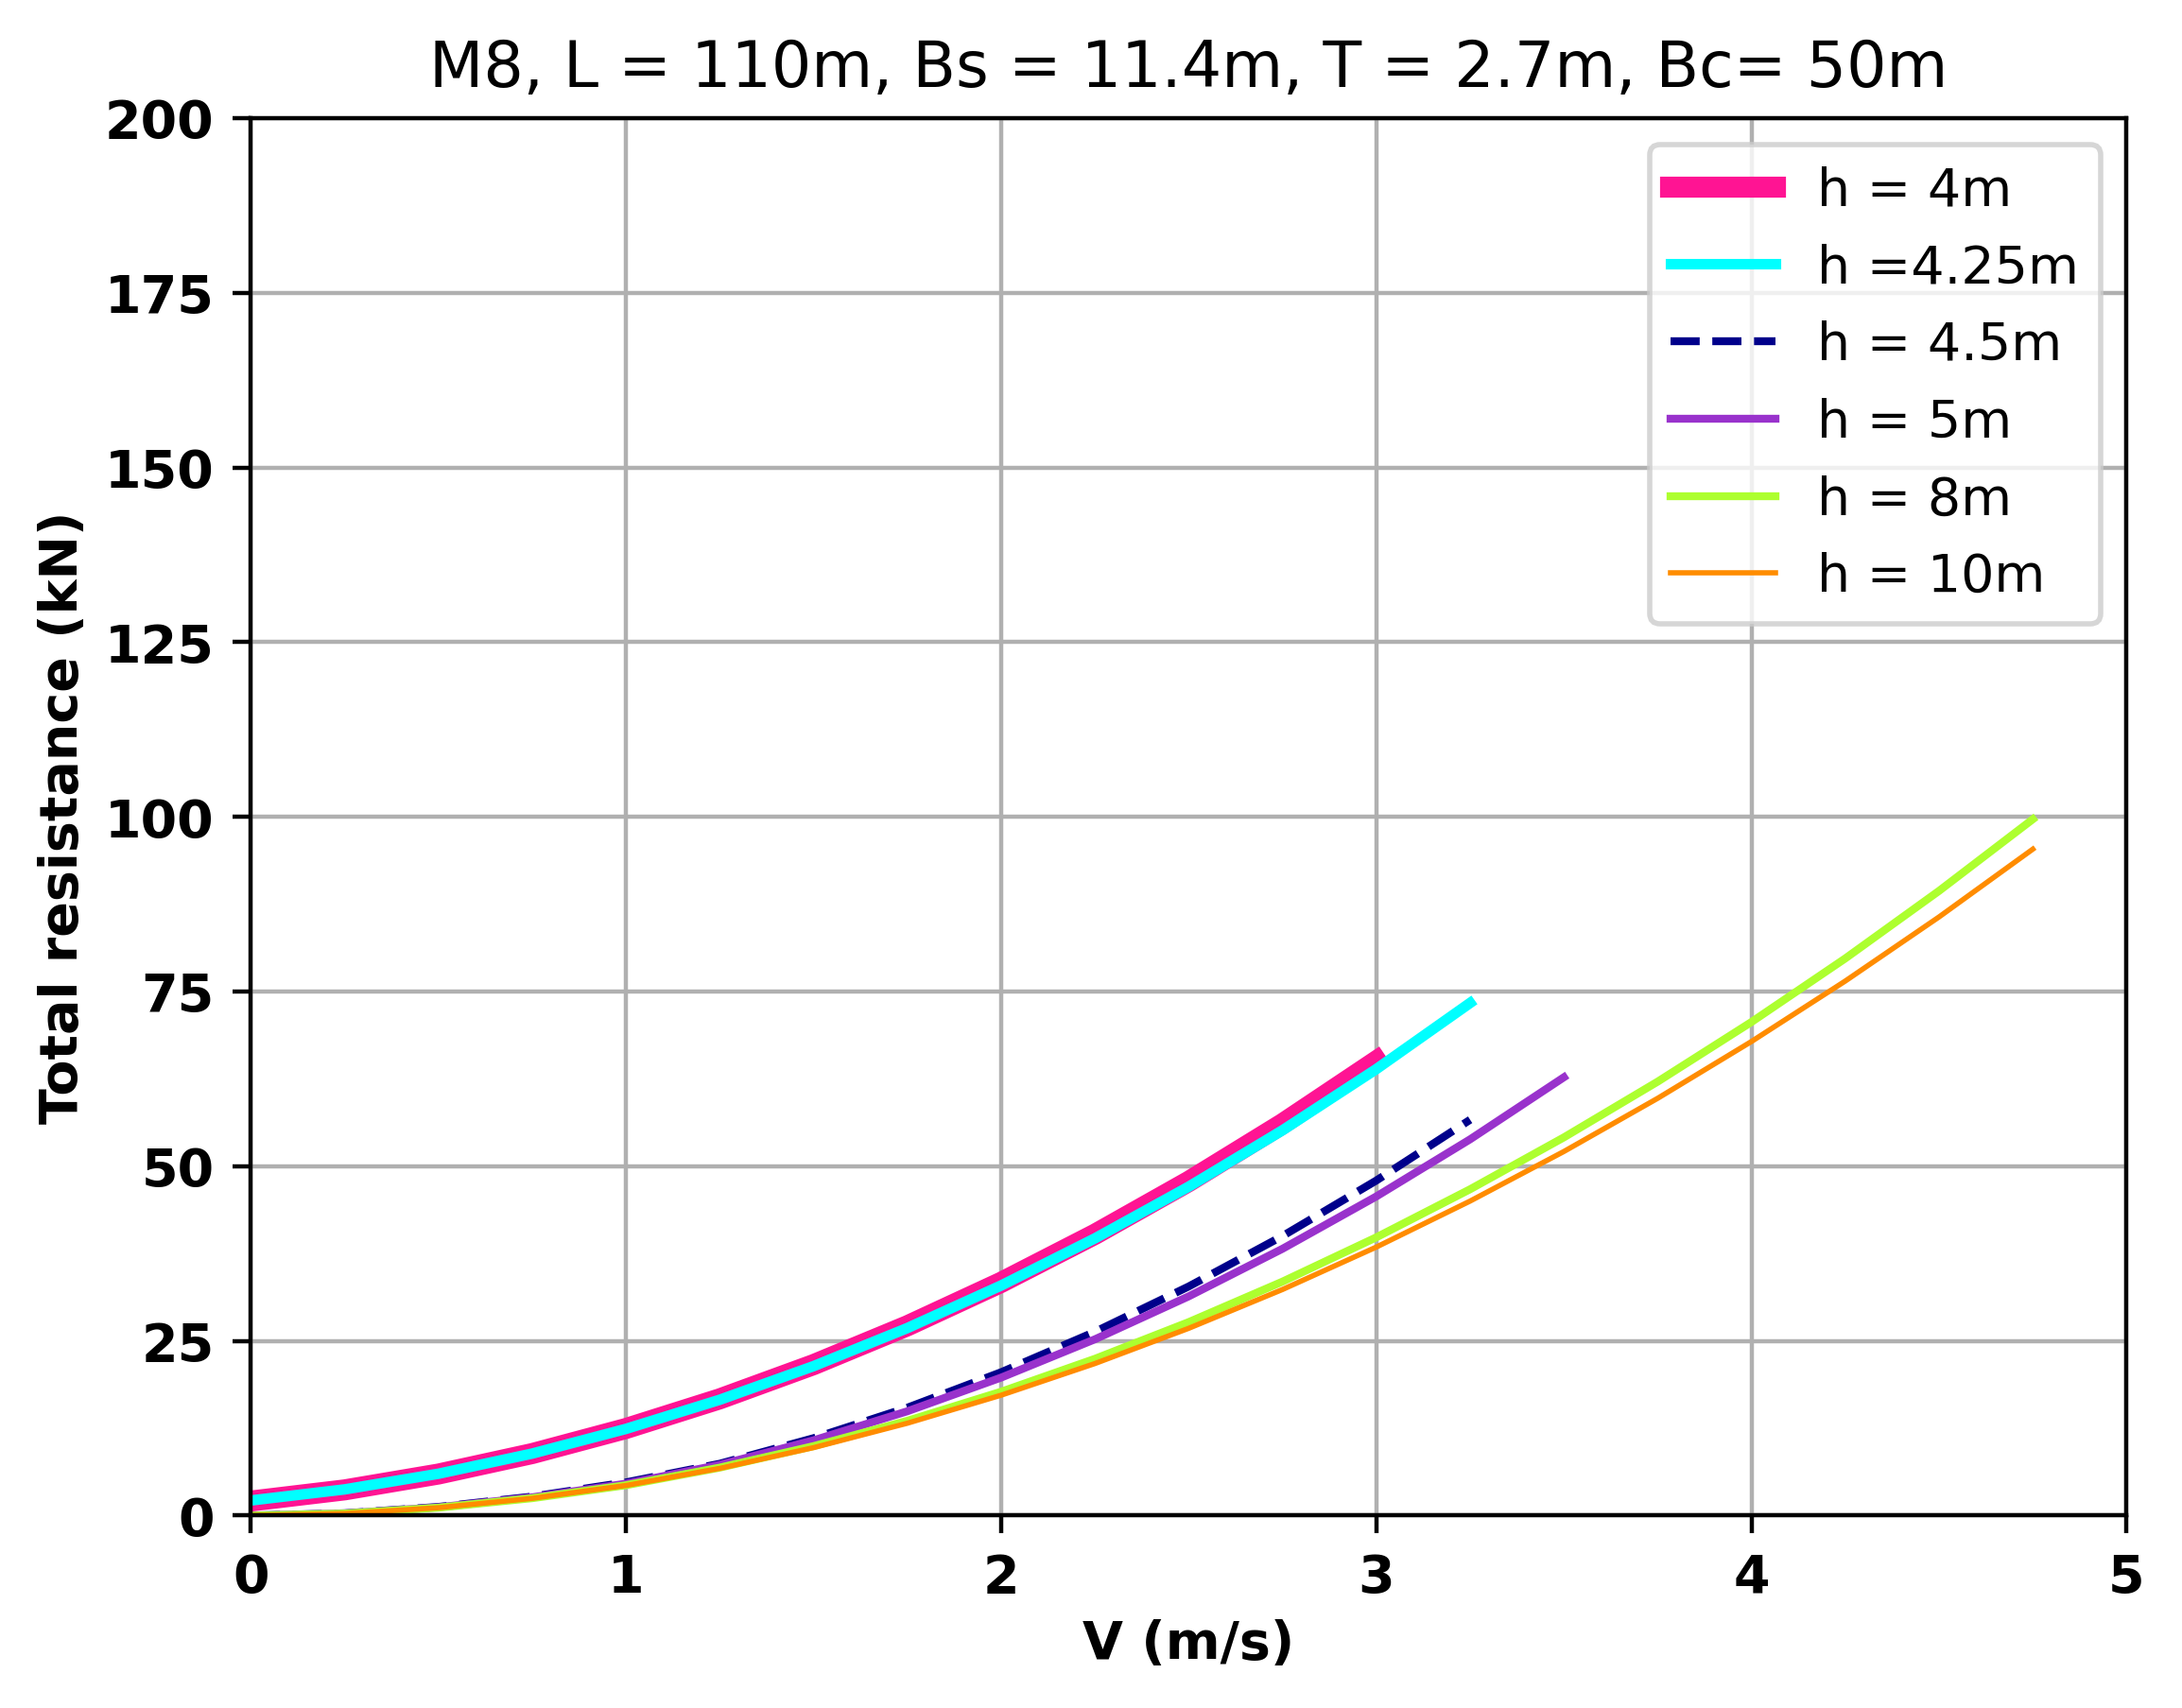

In [8]:
selected_h_4 = plot_df.query('h_more == 4 & V_more <= 3')
selected_h_4_2 = plot_df.query('h_more == 4.25 & V_more <= 3.25')
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3.3')
selected_h_5 = plot_df.query('h_more == 5 & V_more <= 3.5')
selected_h_8 = plot_df.query('h_more == 8 & V_more <= 4.8')
selected_h_10 = plot_df.query('h_more == 10 & V_more <= 4.8')

plt.figure(dpi=400)
plt.plot(selected_h_4['V_more'],selected_h_4['Rtot'], 'deeppink', linewidth = 4)
plt.plot(selected_h_4_2['V_more'],selected_h_4_2['Rtot'], 'cyan', linewidth = 2)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Rtot'], 'darkblue', linewidth = 1.5, linestyle = 'dashed')
plt.plot(selected_h_5['V_more'],selected_h_5['Rtot'], 'darkorchid', linewidth = 1.5)
plt.plot(selected_h_8['V_more'],selected_h_8['Rtot'], 'greenyellow', linewidth = 1.5)
plt.plot(selected_h_10['V_more'],selected_h_10['Rtot'], 'darkorange', linewidth = 1)

plt.grid()
plt.xlim(0,5)
plt.ylim(0,200)
plt.legend(['h = 4m','h =4.25m','h = 4.5m','h = 5m','h = 8m','h = 10m'])
plt.xlabel('V (m/s)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Total resistance (kN)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('M8-Henk Rtot-Vs.pdf',dpi=600, format='pdf')
plt.title('M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 50m')

Text(0.5, 1.0, 'M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 50m')

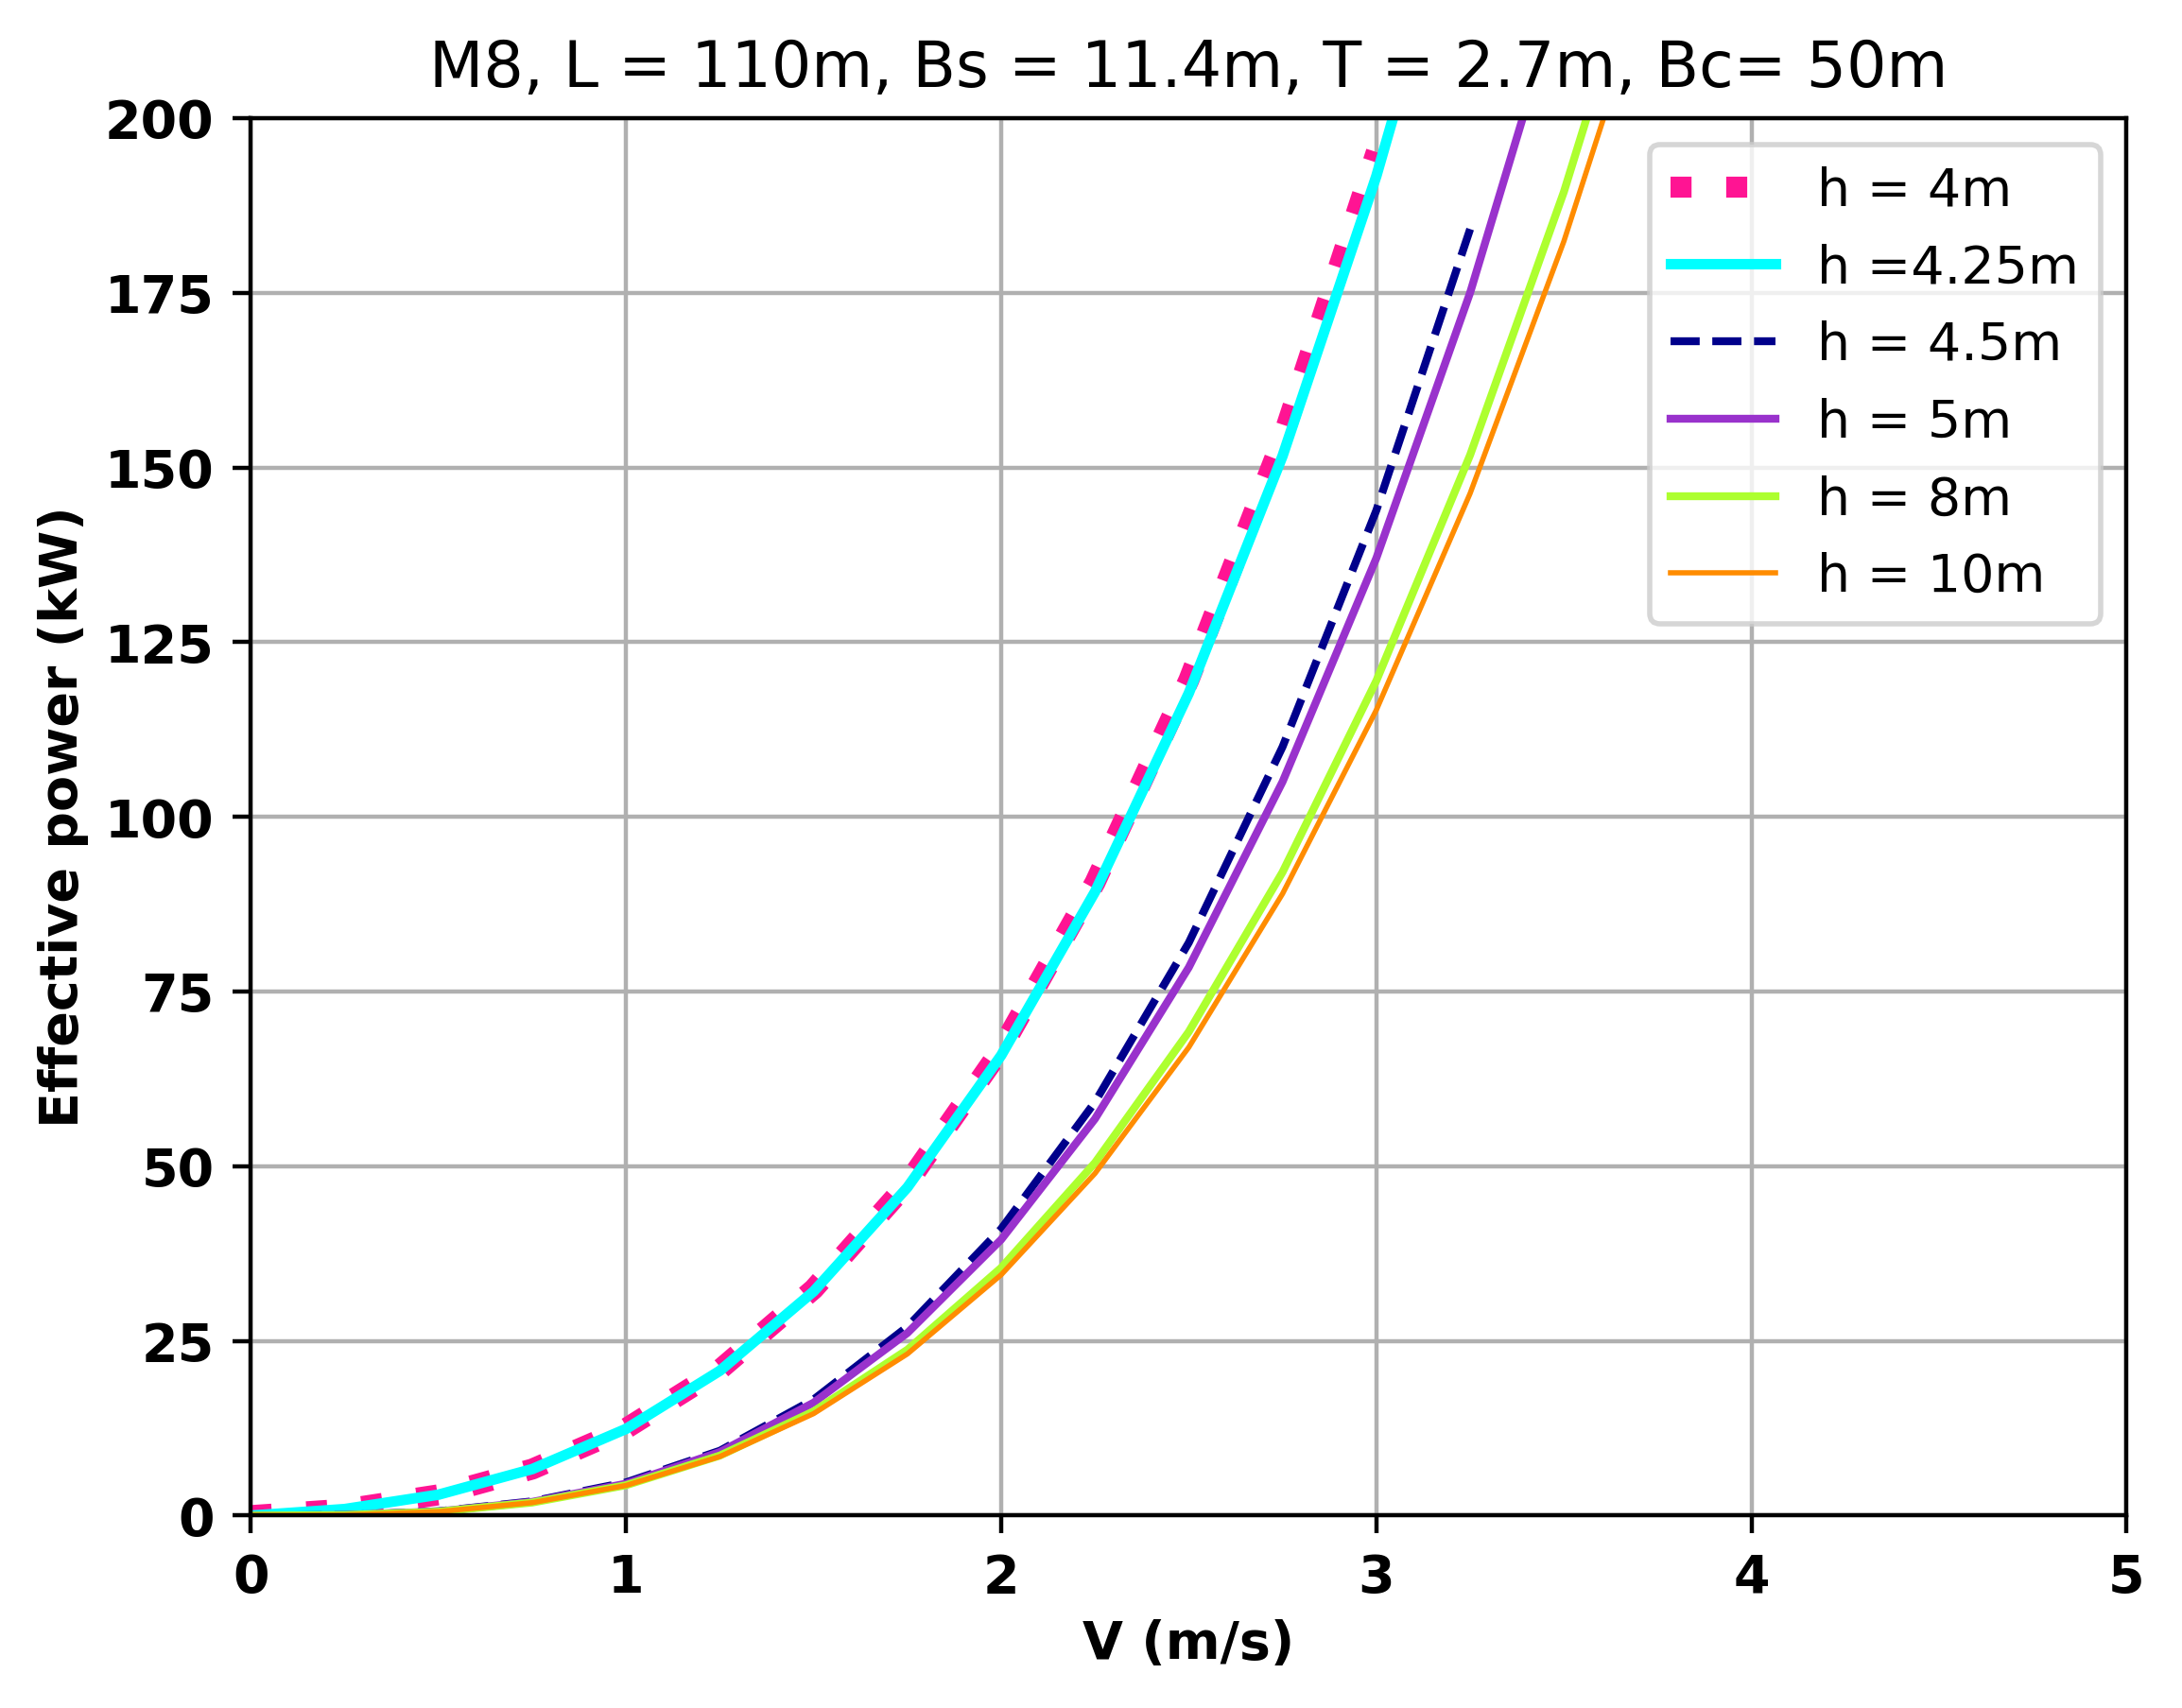

In [9]:
selected_h_4 = plot_df.query('h_more == 4 & V_more <= 3')
selected_h_4_2 = plot_df.query('h_more == 4.25 & V_more <= 3.25')
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3.3')
selected_h_5 = plot_df.query('h_more == 5 & V_more <= 3.5')
selected_h_8 = plot_df.query('h_more == 8 & V_more <= 4.8')
selected_h_10 = plot_df.query('h_more == 10 & V_more <= 4.8')

plt.figure(dpi=400)
plt.plot(selected_h_4['V_more'],selected_h_4['Pe'], 'deeppink', linewidth = 4, linestyle = 'dotted')
plt.plot(selected_h_4_2['V_more'],selected_h_4_2['Pe'], 'cyan', linewidth = 2)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Pe'], 'darkblue', linewidth = 1.5, linestyle = 'dashed')
plt.plot(selected_h_5['V_more'],selected_h_5['Pe'], 'darkorchid', linewidth = 1.5)
plt.plot(selected_h_8['V_more'],selected_h_8['Pe'], 'greenyellow', linewidth = 1.5)
plt.plot(selected_h_10['V_more'],selected_h_10['Pe'], 'darkorange', linewidth = 1)

plt.grid()
plt.xlim(0,5)
plt.ylim(0,200)
plt.legend(['h = 4m','h =4.25m','h = 4.5m','h = 5m','h = 8m','h = 10m'])
plt.xlabel('V (m/s)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Effective power (kW)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('M8-Henk Pe-Vs.pdf', dpi=600, format='pdf')
plt.title('M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 50m')

Text(0.5, 1.0, 'M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 150m')

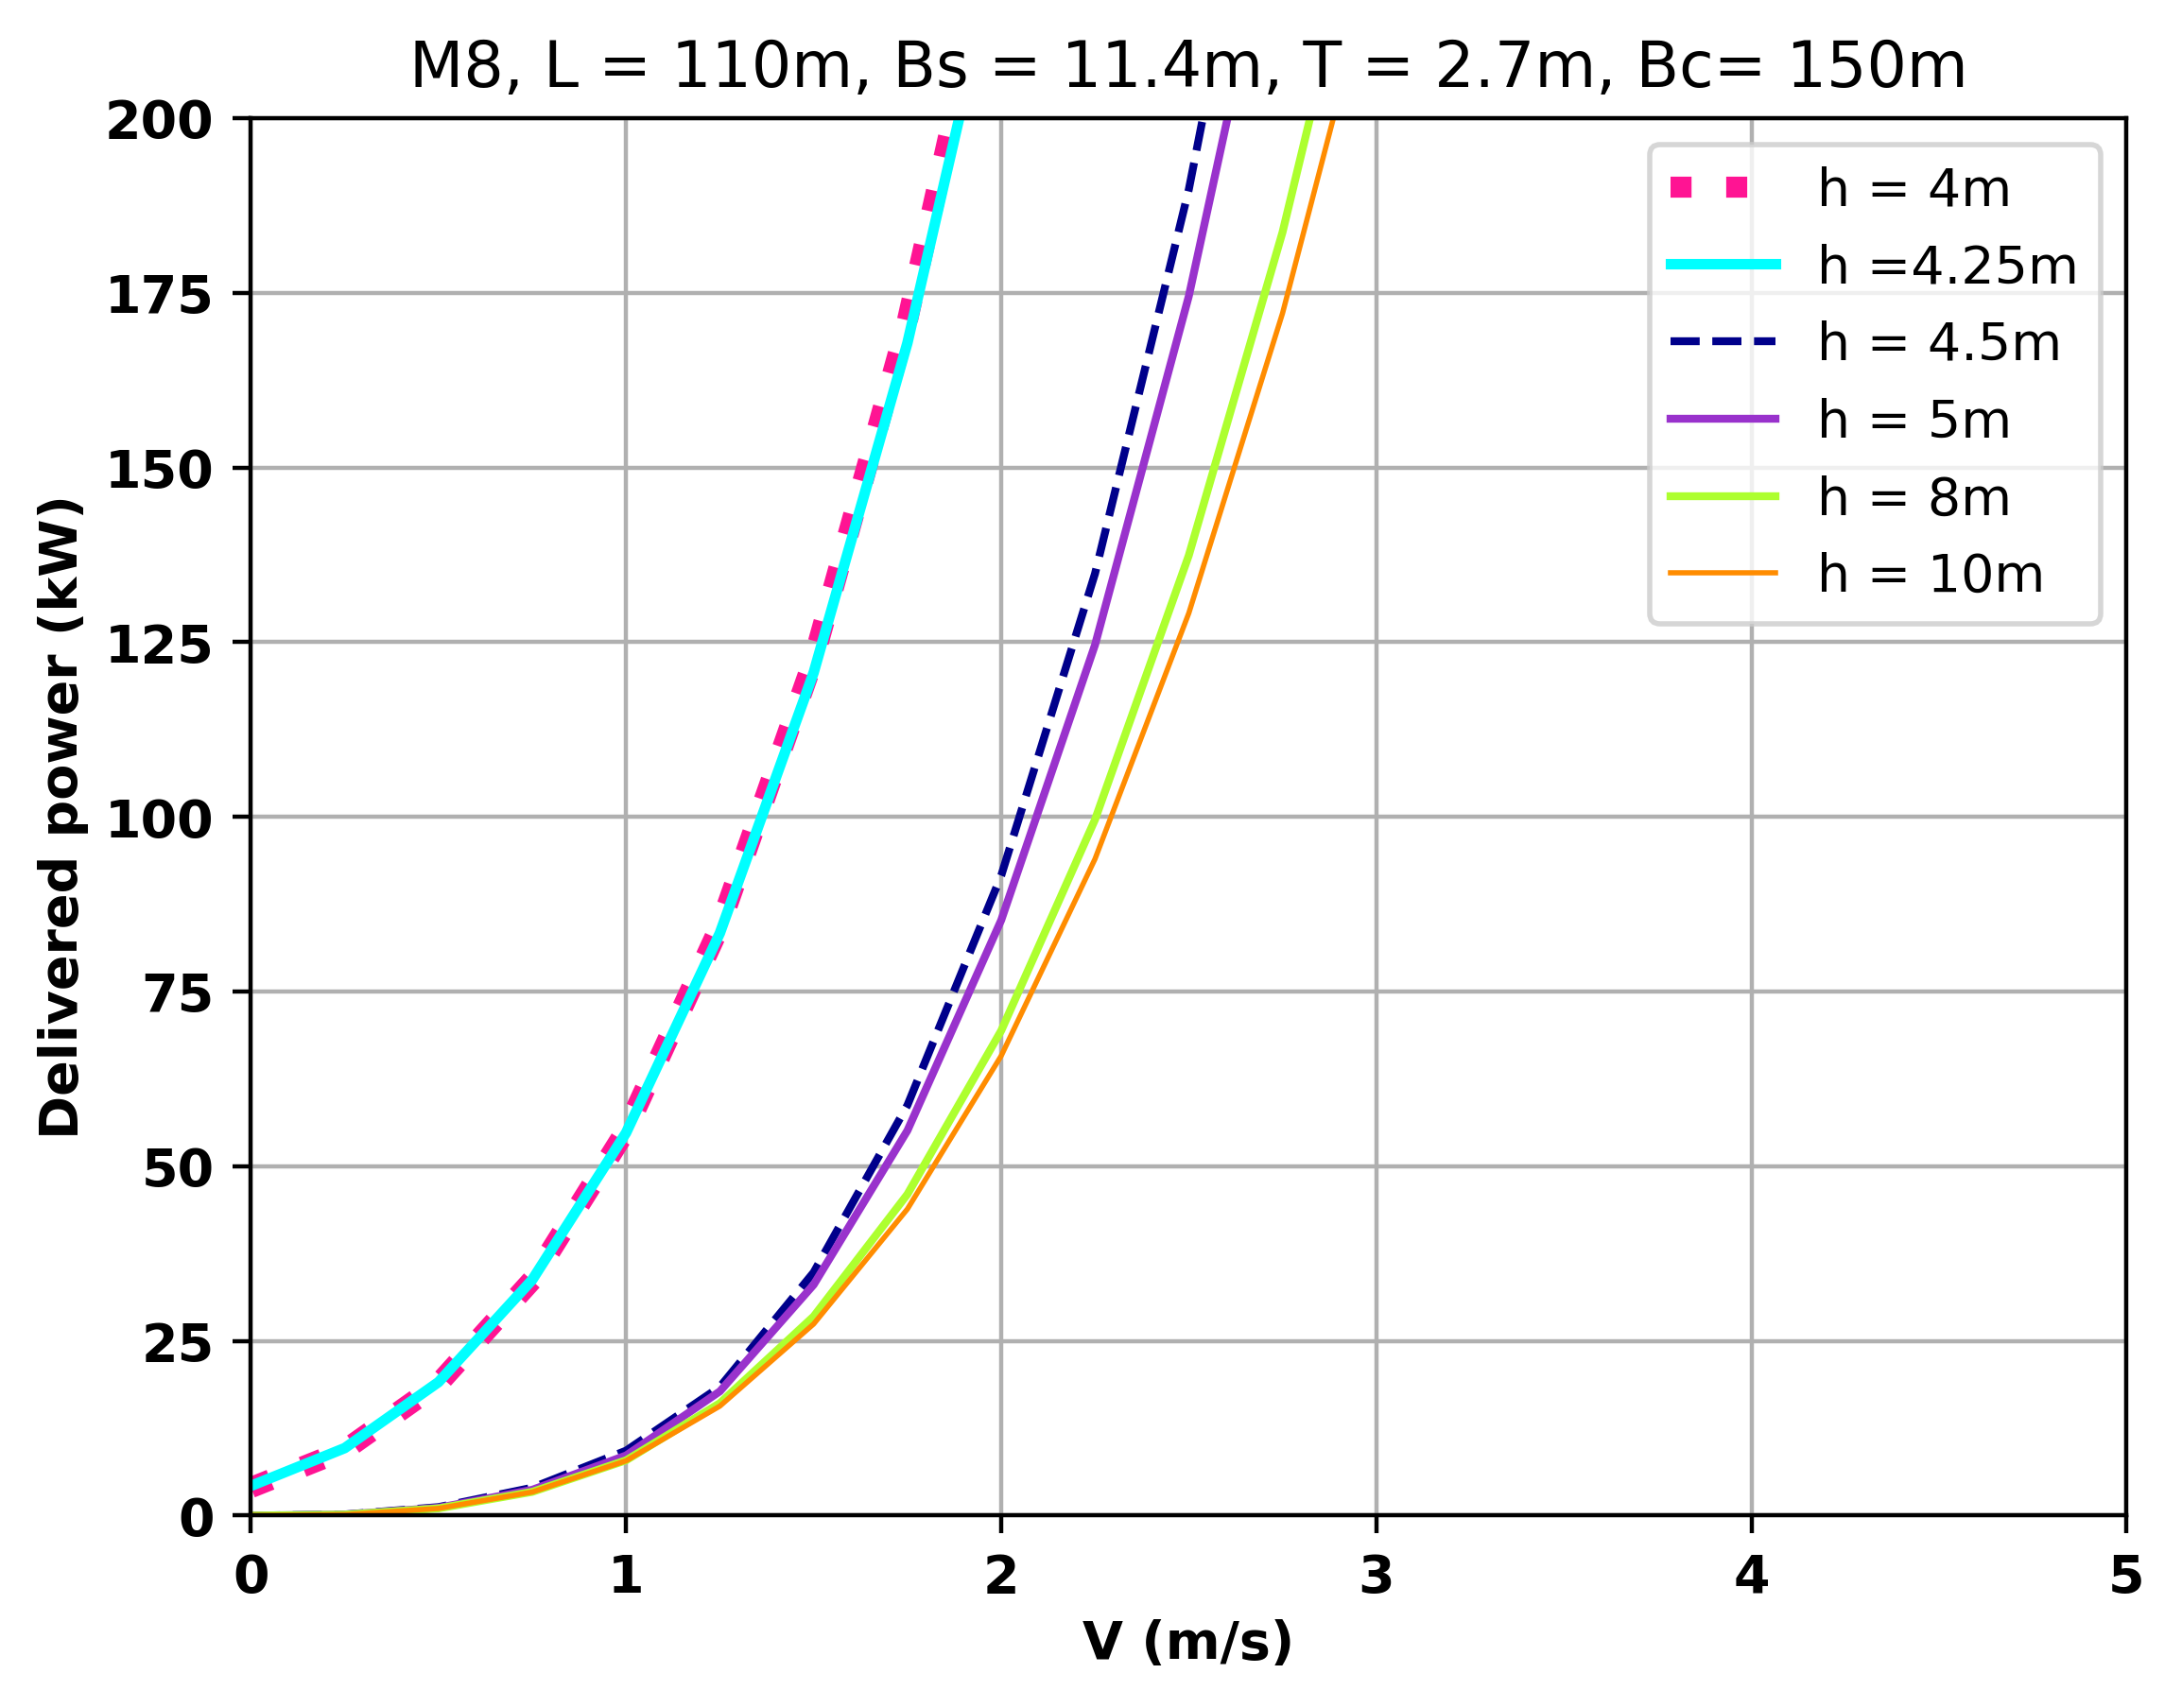

In [10]:
selected_h_4 = plot_df.query('h_more == 4 & V_more <= 3')
selected_h_4_2 = plot_df.query('h_more == 4.25 & V_more <= 3.25')
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3.3')
selected_h_5 = plot_df.query('h_more == 5 & V_more <= 3.5')
selected_h_8 = plot_df.query('h_more == 8 & V_more <= 4.8')
selected_h_10 = plot_df.query('h_more == 10 & V_more <= 4.8')

plt.figure(dpi=400)
plt.plot(selected_h_4['V_more'],selected_h_4['Pd'], 'deeppink', linewidth = 4, linestyle = 'dotted')
plt.plot(selected_h_4_2['V_more'],selected_h_4_2['Pd'], 'cyan', linewidth = 2)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Pd'], 'darkblue', linewidth = 1.5, linestyle = 'dashed')
plt.plot(selected_h_5['V_more'],selected_h_5['Pd'], 'darkorchid', linewidth = 1.5)
plt.plot(selected_h_8['V_more'],selected_h_8['Pd'], 'greenyellow', linewidth = 1.5)
plt.plot(selected_h_10['V_more'],selected_h_10['Pd'], 'darkorange', linewidth = 1)

plt.grid()
plt.xlim(0,5)
plt.ylim(0,200)
plt.legend(['h = 4m','h =4.25m','h = 4.5m','h = 5m','h = 8m','h = 10m'])
plt.xlabel('V (m/s)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Delivered power (kW)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('w-M8-Henk Pd-Vs.pdf', dpi=100, format='pdf') 
plt.title('M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 150m')

Text(0.5, 1.0, 'M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 50m')

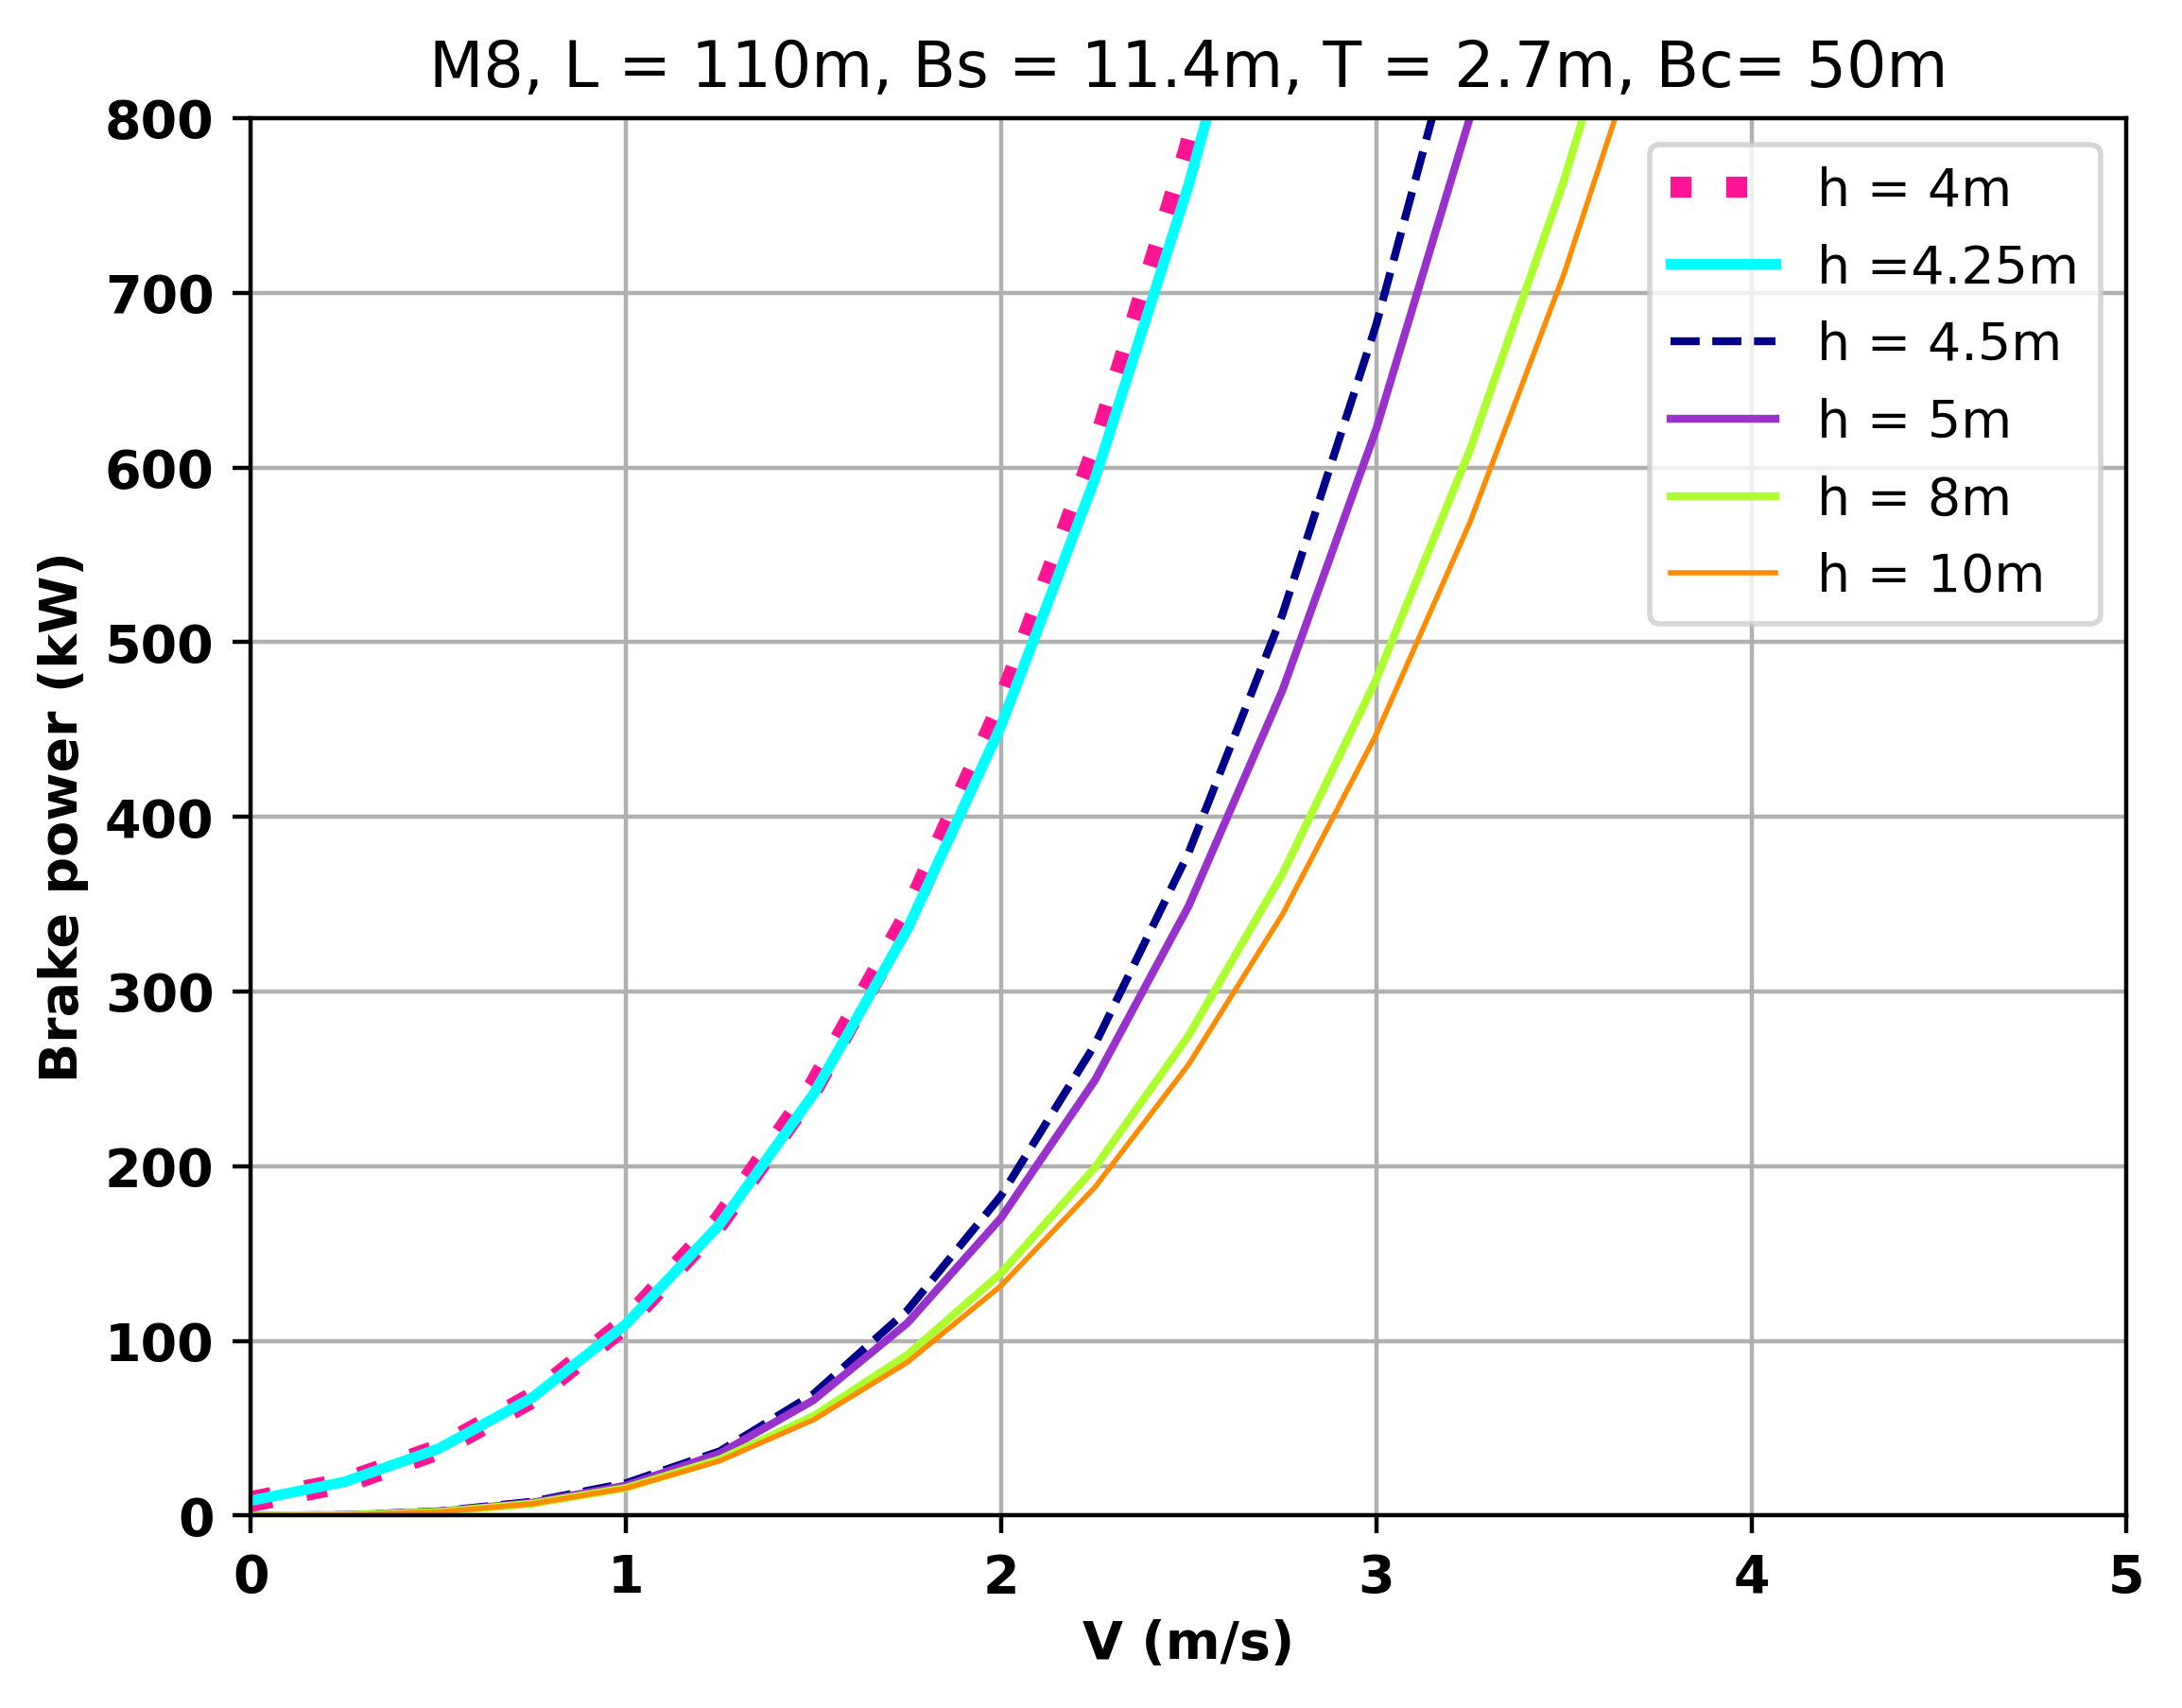

In [11]:
selected_h_4 = plot_df.query('h_more == 4 & V_more <= 3')
selected_h_4_2 = plot_df.query('h_more == 4.25 & V_more <= 3.25')
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3.3')
selected_h_5 = plot_df.query('h_more == 5 & V_more <= 3.5')
selected_h_8 = plot_df.query('h_more == 8 & V_more <= 4.8')
selected_h_10 = plot_df.query('h_more == 10 & V_more <= 4.8')
plt.figure(dpi=400)
plt.plot(selected_h_4['V_more'],selected_h_4['Pb'], 'deeppink', linewidth = 4, linestyle = 'dotted')
plt.plot(selected_h_4_2['V_more'],selected_h_4_2['Pb'], 'cyan', linewidth = 2)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Pb'], 'darkblue', linewidth = 1.5, linestyle = 'dashed')
plt.plot(selected_h_5['V_more'],selected_h_5['Pb'], 'darkorchid', linewidth = 1.5)
plt.plot(selected_h_8['V_more'],selected_h_8['Pb'], 'greenyellow', linewidth = 1.5)
plt.plot(selected_h_10['V_more'],selected_h_10['Pb'], 'darkorange', linewidth = 1)

plt.grid()
plt.xlim(0,5)
plt.ylim(0,800)
plt.legend(['h = 4m','h =4.25m','h = 4.5m','h = 5m','h = 8m','h = 10m'])
plt.xlabel('V (m/s)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Brake power (kW)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('M8-Henk Pb-Vs.pdf',dpi=600, format='pdf')
plt.title('M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 50m')